In [1]:
import pandas as pd

DATASET_FILE = "../data/train.csv"

In [2]:
from disaster_tweets.sklearn_models import get_dataset

train_data, test_data = get_dataset(DATASET_FILE)

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


MODELS = {
    "sgd": SGDClassifier(),
    "random forest": RandomForestClassifier(),
    "svc": SVC(),
}

In [4]:
from sklearn.metrics import classification_report

def train_and_test(model):
    model.fit(train_data, train_data["target"])
    predictions = model.predict(test_data)
    return classification_report(test_data["target"], predictions, output_dict=True)

In [5]:
from time import perf_counter
from disaster_tweets.sklearn_models import create_pipeline, classification_heatmap, report_to_df

reports = {}
for name, classifier in MODELS.items():
    start = perf_counter()
    model = create_pipeline(classifier)
    report = report_to_df(train_and_test(model))
    end = perf_counter()
    print()
    print(f"model: {name}, training time: {end - start}s")
    print(report)
    reports[name] = report


model: sgd, training time: 0.17811935499776155s
              precision    recall  f1-score
0              0.784810  0.834081  0.808696
1              0.742609  0.676704  0.708126
accuracy       0.768877  0.768877  0.768877
macro avg      0.763709  0.755392  0.758411
weighted avg   0.767325  0.768877  0.767028

model: random forest, training time: 6.799507906995132s
              precision    recall  f1-score
0              0.745961  0.931614  0.828514
1              0.850856  0.551506  0.669231
accuracy       0.774130  0.774130  0.774130
macro avg      0.798408  0.741560  0.748873
weighted avg   0.789420  0.774130  0.762521

model: svc, training time: 6.126406499010045s
              precision    recall  f1-score
0              0.752336  0.902466  0.820591
1              0.807947  0.580032  0.675277
accuracy       0.768877  0.768877  0.768877
macro avg      0.780142  0.741249  0.747934
weighted avg   0.775377  0.768877  0.760385


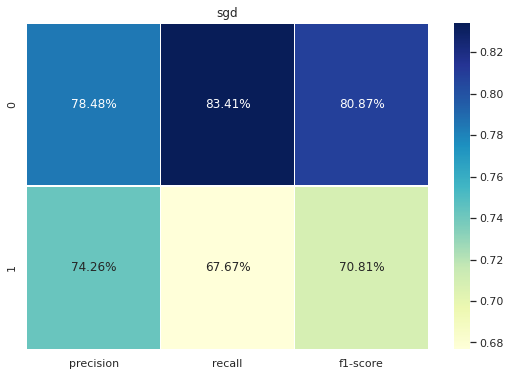

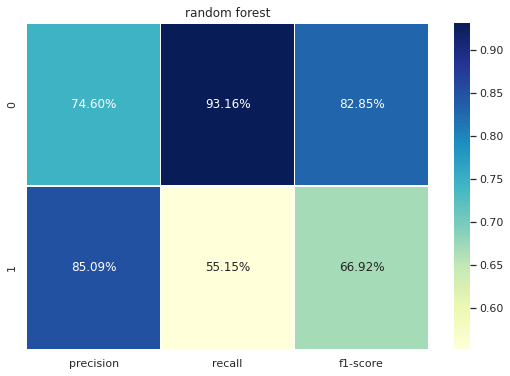

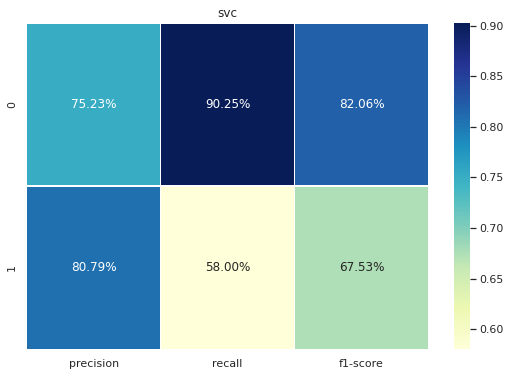

In [6]:
for name, report in reports.items():
    classification_heatmap(report, name)

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

sgd_model = create_pipeline(SGDClassifier())
sgd_model.get_params()

{'memory': None,
 'steps': [('column',
   ColumnTransformer(transformer_weights={'keyword': 0, 'location': 0, 'text': 1},
                     transformers=[('text',
                                    CountVectorizer(lowercase=False,
                                                    tokenizer=<function tokenize at 0x7fd9903a7c10>),
                                    'text'),
                                   ('keyword',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['keyword']),
                                   ('location',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['location'])])),
  ('classifier', SGDClassifier())],
 'verbose': False,
 'column': ColumnTransformer(transformer_weights={'keyword': 0, 'location': 0, 'text': 1},
                   transformers=[('text',
                                  CountVectorizer(lowercase=False,
            

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

params = {
    "classifier__loss": ["hinge", "log", "modified_huber", "squared_hinge"],
    "classifier__max_iter": [1000, 10_000, 100],
}

grid_search = GridSearchCV(sgd_model, params, scoring=make_scorer(f1_score))
grid_search.fit(train_data, train_data["target"])
grid_search.cv_results_

{'mean_fit_time': array([0.12142925, 0.1265182 , 0.13212118, 0.12386646, 0.11903787,
        0.13296928, 0.12780175, 0.12624559, 0.1199924 , 0.12953157,
        0.12217302, 0.13026371]),
 'std_fit_time': array([0.0095348 , 0.00949054, 0.00925459, 0.00730645, 0.00430706,
        0.01510904, 0.01054055, 0.00828428, 0.00425667, 0.01100384,
        0.00474729, 0.01818176]),
 'mean_score_time': array([0.03382463, 0.03395839, 0.03104796, 0.03337755, 0.0333138 ,
        0.03384051, 0.03363409, 0.03354321, 0.0333251 , 0.03323336,
        0.03298597, 0.03324294]),
 'std_score_time': array([0.00056873, 0.00057298, 0.00469708, 0.00050803, 0.00057866,
        0.00079585, 0.00095831, 0.00043263, 0.00031354, 0.00048675,
        0.00013528, 0.000543  ]),
 'param_classifier__loss': masked_array(data=['hinge', 'hinge', 'hinge', 'log', 'log', 'log',
                    'modified_huber', 'modified_huber', 'modified_huber',
                    'squared_hinge', 'squared_hinge', 'squared_hinge'],
          

In [9]:
grid_search.best_estimator_, grid_search.best_score_

(Pipeline(steps=[('column',
                  ColumnTransformer(transformer_weights={'keyword': 0,
                                                         'location': 0,
                                                         'text': 1},
                                    transformers=[('text',
                                                   CountVectorizer(lowercase=False,
                                                                   tokenizer=<function tokenize at 0x7fd9903a7c10>),
                                                   'text'),
                                                  ('keyword',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['keyword']),
                                                  ('location',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['location'])])),

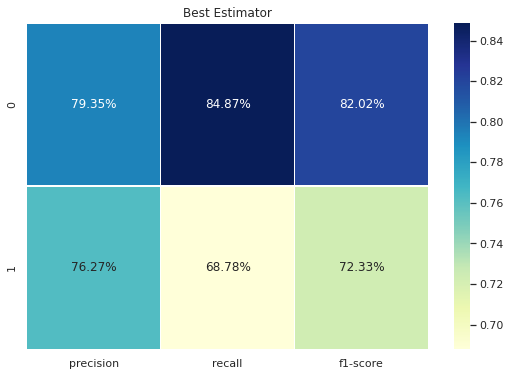

In [10]:
model = grid_search.best_estimator_
predictions = model.predict(test_data)
report = classification_report(test_data["target"], predictions, output_dict=True)
classification_heatmap(report_to_df(report), "Best Estimator")

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from disaster_tweets.tokenizer import tokenize

sgd_model_tuned = create_pipeline(SGDClassifier(loss="log", max_iter=10_000), vectorizer=TfidfVectorizer, tokenizer=tokenize)
start = perf_counter()
report = report_to_df(train_and_test(sgd_model_tuned))
end = perf_counter()
end - start

46.331986239994876

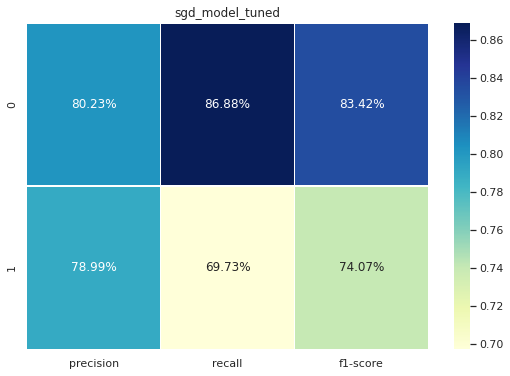

In [13]:
classification_heatmap(report, "sgd_model_tuned")

In [14]:
report

,precision,recall,f1-score
0,0.802277,0.868834,0.834230
1,0.789946,0.697306,0.740741
accuracy,0.797768,0.797768,0.797768
macro avg,0.796112,0.783070,0.787486
weighted avg,0.797168,0.797768,0.795496
